<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN/CNN_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 6.01 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat Jul 17 16:53:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 14.3MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 174kB 44.8MB/s 
     |████████████████████████████████| 143kB 47.2MB/s 
     |████████████████████████████████| 143kB 45.7MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['selu', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Conv1D(filters=128, kernel_size=2, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Conv1D(filters=64, kernel_size=2, activation=config.activation))
    # layer 3
    model.add(MaxPooling1D(pool_size=2))
    # layer 4
    model.add(Flatten())
    # layer 5
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: v635m1w0
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN/sweeps/v635m1w0


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 2swwphi4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
31/31 [==============================] - 30s 23ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0671 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1185
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0390 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0977
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0269 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0923
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0396 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0871
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_err

epoch,67
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01357
val_loss,0.00521
val_mean_squared_error,0.00521
val_mean_absolute_error,0.0565
_runtime,50
_timestamp,1626540932
_step,67
best_val_loss,0.00508


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▄▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▄▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▅▃▂▂▂▂▃▂▂▂▁▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▆▅▄▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: iw7e7mml with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 24ms/step - loss: 0.0857 - mean_squared_error: 0.0857 - mean_absolute_error: 0.2163 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1492
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1466
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0452 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1311
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0389 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1337
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_erro

epoch,82
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.015
val_loss,0.00561
val_mean_squared_error,0.00561
val_mean_absolute_error,0.05584
_runtime,14
_timestamp,1626540967
_step,82
best_val_loss,0.00484


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▅▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▅▅▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▅▅▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zosgtmez with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 56ms/step - loss: 0.1555 - mean_squared_error: 0.1555 - mean_absolute_error: 0.2885 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1675
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1107 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1701
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0690 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1200
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0461 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1202
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 

epoch,199
loss,0.0003
mean_squared_error,0.0003
mean_absolute_error,0.01279
val_loss,0.00475
val_mean_squared_error,0.00475
val_mean_absolute_error,0.05234
_runtime,21
_timestamp,1626541008
_step,199
best_val_loss,0.00475


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xbu1dju7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 50ms/step - loss: 0.0900 - mean_squared_error: 0.0900 - mean_absolute_error: 0.2222 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1706
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0754 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1372
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1487
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0456 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1282
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 

epoch,199
loss,0.00029
mean_squared_error,0.00029
mean_absolute_error,0.01236
val_loss,0.00493
val_mean_squared_error,0.00493
val_mean_absolute_error,0.05419
_runtime,20
_timestamp,1626541041
_step,199
best_val_loss,0.00489


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: la2cv2ql with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.1284 - mean_squared_error: 0.1284 - mean_absolute_error: 0.1930 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1240
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0516 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1153
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0566 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1171
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0599 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1096
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_erro

epoch,62
loss,0.00066
mean_squared_error,0.00066
mean_absolute_error,0.01956
val_loss,0.00606
val_mean_squared_error,0.00606
val_mean_absolute_error,0.06033
_runtime,12
_timestamp,1626541069
_step,62
best_val_loss,0.00537


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁
val_loss,▄▃▃▃█▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃▃▃█▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▄▄▃█▃▄▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁
_runtime,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: y7vz5lk2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 1s 49ms/step - loss: 0.4027 - mean_squared_error: 0.4027 - mean_absolute_error: 0.4235 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1631
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0732 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1103
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0688 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1193
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0617 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1010
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018

epoch,49
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.02228
val_loss,0.00957
val_mean_squared_error,0.00957
val_mean_absolute_error,0.0772
_runtime,11
_timestamp,1626541090
_step,49
best_val_loss,0.00624


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
mean_absolute_error,▃▁▂▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▂▁
val_loss,▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
val_mean_squared_error,▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
val_mean_absolute_error,▂▁▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xaomzbu3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 48ms/step - loss: 0.4201 - mean_squared_error: 0.4201 - mean_absolute_error: 0.4469 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1141
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0983 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1091
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0637 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1090
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0454 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1066
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mea

epoch,49
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01436
val_loss,0.00553
val_mean_squared_error,0.00553
val_mean_absolute_error,0.05898
_runtime,9
_timestamp,1626541109
_step,49
best_val_loss,0.00553


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▇▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇█▇▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g23k5z3i with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 53ms/step - loss: 0.1849 - mean_squared_error: 0.1849 - mean_absolute_error: 0.3262 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1277
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0512 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1365
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0411 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1298
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0381 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1280
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 

epoch,42
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.0322
val_loss,0.01233
val_mean_squared_error,0.01233
val_mean_absolute_error,0.08705
_runtime,9
_timestamp,1626541128
_step,42
best_val_loss,0.01176


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇▆▆▅▆█▅▆▄▄▃▃▃▃▂▄▃▅▃▆▂▂▂▂▁▅▁▃▁▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,▅▇▆▆▅▆█▅▆▄▄▃▃▃▃▂▄▃▅▃▆▂▂▂▂▁▅▁▃▁▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,▆▇▆▆▆▆█▅▆▅▄▄▄▃▃▃▅▃▅▃▆▂▂▂▂▂▅▁▃▁▁▁▁▁▂▁▁▂▁▁
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆█████████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆█████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: loov0vg0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 28ms/step - loss: 0.2263 - mean_squared_error: 0.2263 - mean_absolute_error: 0.3235 - val_loss: 0.0710 - val_mean_squared_error: 0.0710 - val_mean_absolute_error: 0.2250
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0748 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1063
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0938
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0703 - val_loss: 0.0689 - val_mean_squared_error: 0.0689 - val_mean_absolute_error: 0.2304
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.1725 - mean_squared_erro

epoch,45
loss,0.00063
mean_squared_error,0.00063
mean_absolute_error,0.0183
val_loss,0.00786
val_mean_squared_error,0.00786
val_mean_absolute_error,0.07039
_runtime,12
_timestamp,1626541152
_step,45
best_val_loss,0.00549


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁
mean_absolute_error,▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▂▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁
val_mean_absolute_error,▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: wnibz0nw with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 1s 15ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - mean_absolute_error: 0.1703 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0999
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0318 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0846
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 9.7337e-04 - mean_squared_error: 9.7337e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0818
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 8.5103e-04 - mean_squared_error: 8.5103e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0769
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 8.5553e-04 - me

epoch,49
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01436
val_loss,0.00496
val_mean_squared_error,0.00496
val_mean_absolute_error,0.05301
_runtime,15
_timestamp,1626541179
_step,49
best_val_loss,0.00483


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▄▃▃▄▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▄▃▃▄▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▄▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q952hd1e with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0546 - mean_squared_error: 0.0546 - mean_absolute_error: 0.1461 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1375
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0417 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1327
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0411 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1166
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0388 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1101
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_erro

epoch,92
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01548
val_loss,0.00576
val_mean_squared_error,0.00576
val_mean_absolute_error,0.05674
_runtime,24
_timestamp,1626541216
_step,92
best_val_loss,0.00496


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆█▆▄▄▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▂▁▂▂▁▂▂▁▁▂▁▁
val_mean_squared_error,█▆█▆▄▄▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▂▁▂▂▁▂▂▁▁▂▁▁
val_mean_absolute_error,█▆█▆▄▄▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▂▂▁▂▂▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eagupdu6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 16ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1234 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1168
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0589 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1103
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0488 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1078
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0409 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1009
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.

epoch,22
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02423
val_loss,0.01078
val_mean_squared_error,0.01078
val_mean_absolute_error,0.08256
_runtime,11
_timestamp,1626541240
_step,22
best_val_loss,0.01042


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▁▂▁▁▁▁▅▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▂▁▁▁▁▅▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▄▃▄▃▂▄▂▂▂▂▇▂▂▂▂▁▂▂▁
val_loss,▅▄▄▃▂▂▄▃▂▁█▁▁▁▂▂▁▂▁▃▂▁▁
val_mean_squared_error,▅▄▄▃▂▂▄▃▂▁█▁▁▁▂▂▁▂▁▃▂▁▁
val_mean_absolute_error,▅▄▄▃▃▃▄▄▃▂█▁▁▁▂▂▂▂▁▄▂▁▁
_runtime,▁▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇███
_timestamp,▁▂▂▂▂▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: jnkvdjf2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 29ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - mean_absolute_error: 0.1376 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1151
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1095
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0343 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1023
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0302 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1304
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_erro

epoch,36
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.0242
val_loss,0.00907
val_mean_squared_error,0.00907
val_mean_absolute_error,0.07539
_runtime,16
_timestamp,1626541271
_step,36
best_val_loss,0.00731


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▃▂▁▁▂▃▁▁▂▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▂▁▁▂▃▁▁▂▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▄▃▂▂▃▄▂▂▃▂▃▂▁▂▂▃▂▂▂▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁
val_loss,▅▄▄▇▅▃▄▃▅▃▃▃▂█▂▃▃▂▃▂▂▂▂█▂▂▁▂▂▂▂▂▂▂▂▂▂
val_mean_squared_error,▅▄▄▇▅▃▄▃▅▃▃▃▂█▂▃▃▂▃▂▂▂▂█▂▂▁▂▂▂▂▂▂▂▂▂▂
val_mean_absolute_error,▅▅▄▇▅▄▄▃▅▃▃▃▃█▃▃▃▂▃▂▃▂▂█▂▂▁▂▂▂▂▂▃▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qkwuydu3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 51ms/step - loss: 0.1565 - mean_squared_error: 0.1565 - mean_absolute_error: 0.3205 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.2198
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1547 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1323
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0850 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1697
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0881 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1252
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 

epoch,99
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01531
val_loss,0.00694
val_mean_squared_error,0.00694
val_mean_absolute_error,0.06495
_runtime,16
_timestamp,1626541307
_step,99
best_val_loss,0.00679


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oyf5g3uk with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - mean_absolute_error: 0.1168 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1227
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0364 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1102
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0302 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0977
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0251 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0917
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0010 - mean_squared_error: 0.

epoch,49
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01341
val_loss,0.00544
val_mean_squared_error,0.00544
val_mean_absolute_error,0.05683
_runtime,16
_timestamp,1626541336
_step,49
best_val_loss,0.0054


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z5wvqbj0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 52ms/step - loss: 0.0827 - mean_squared_error: 0.0827 - mean_absolute_error: 0.2008 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1605
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0607 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1505
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0442 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1291
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0338 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1233
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072

epoch,42
loss,0.00446
mean_squared_error,0.00446
mean_absolute_error,0.05489
val_loss,0.01399
val_mean_squared_error,0.01399
val_mean_absolute_error,0.09223
_runtime,11
_timestamp,1626541369
_step,42
best_val_loss,0.01267


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▁▁▂▂▁▁▁▂▁▂▂▁▂▂▁▁▁▂▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_squared_error,█▂▁▁▂▂▁▁▁▂▁▂▂▁▂▂▁▁▁▂▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_absolute_error,█▄▂▂▄▃▂▂▂▄▂▃▃▁▃▃▂▁▂▃▂▂▂▃▁▅▁▂▁▁▁▂▂▂▃▂▂▂▁▃
val_loss,█▇▄▄▆▃▃▃▃▄▃▃▃▄▆▄▂▂▅▄▃▂▄▂▁▃▂▂▂▂▁▂▂▂▂▂▂▂▁▁
val_mean_squared_error,█▇▄▄▆▃▃▃▃▄▃▃▃▄▆▄▂▂▅▄▃▂▄▂▁▃▂▂▂▂▁▂▂▂▂▂▂▂▁▁
val_mean_absolute_error,█▇▅▄▆▄▄▄▄▄▄▄▃▄▆▄▃▃▅▄▃▃▄▂▁▃▂▂▂▂▁▃▂▂▂▂▂▂▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆██
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 96lnoy9v with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 2s 26ms/step - loss: 0.1739 - mean_squared_error: 0.1739 - mean_absolute_error: 0.2741 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1292
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0673 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1443
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0889 - val_loss: 0.0490 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1802
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0919 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1398
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 0.0132 - mean_squared_erro

epoch,103
loss,0.00134
mean_squared_error,0.00134
mean_absolute_error,0.02551
val_loss,0.00631
val_mean_squared_error,0.00631
val_mean_absolute_error,0.06051
_runtime,19
_timestamp,1626541402
_step,103
best_val_loss,0.00585


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▅▃▅▄▃▃▃▄▂▂▃▂▂▂▂▂▂▂▁▂▃▁▂▂▃▂▁▂▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,▄█▅▃▅▄▃▃▃▄▂▂▃▂▂▂▂▂▂▂▁▂▃▁▂▂▃▂▁▂▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,▅█▆▄▆▅▄▄▄▅▃▃▄▃▃▃▃▃▂▂▂▃▄▂▂▃▄▂▂▂▁▃▁▃▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5eeuasyu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 54ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - mean_absolute_error: 0.1821 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1534
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0739 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1662
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0756 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1311
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0395 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1256
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - me

epoch,49
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.0144
val_loss,0.0058
val_mean_squared_error,0.0058
val_mean_absolute_error,0.06163
_runtime,11
_timestamp,1626541426
_step,49
best_val_loss,0.0058


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▂▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▂▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▂▃▅▂▂▂▂▂▁▂▄▁▁▁▂▁▁▁▂▁▁▁▁▂▂▁▁▁▂▁▁▁▂▂▁
val_loss,▇█▅▅▄▃▄▄▂▃▂▂▂▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▅▅▄▃▄▄▂▃▂▂▂▂▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▅▅▄▅▅▃▃▃▃▃▂▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████████
_timestamp,▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g1kju0lx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 16ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - mean_absolute_error: 0.1650 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1380
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0367 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1368
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0344 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1277
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0334 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1186
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.

epoch,49
loss,0.00041
mean_squared_error,0.00041
mean_absolute_error,0.01504
val_loss,0.00596
val_mean_squared_error,0.00596
val_mean_absolute_error,0.05932
_runtime,18
_timestamp,1626541457
_step,49
best_val_loss,0.00547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▅▅▃▃▃▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▆▅▅▃▃▃▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▅▅▄▄▄▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3pcivygc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.1060 - mean_squared_error: 0.1060 - mean_absolute_error: 0.1913 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1330
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0852 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1157
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0627 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1061
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0512 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1008
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_erro

epoch,63
loss,0.00067
mean_squared_error,0.00067
mean_absolute_error,0.01947
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.06358
_runtime,16
_timestamp,1626541496
_step,63
best_val_loss,0.00484


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▃▂▃▃▃▃▁▃▁▂▂▃▁▃▁▂▂▂▂▁▂▁▁▁▂▁▂▂▂▂▂▂▂▂▁
val_loss,█▆▄▅▄▄▃▂▂▂▂▃▂▂▄▁▁▅▁▃▁▂▁▂▂▁▅▁▂▁▁▁▂▁▂▁▁▂▁▁
val_mean_squared_error,█▆▄▅▄▄▃▂▂▂▂▃▂▂▄▁▁▅▁▃▁▂▁▂▂▁▅▁▂▁▁▁▂▁▂▁▁▂▁▁
val_mean_absolute_error,█▆▅▅▄▅▃▃▃▂▂▄▃▃▅▂▂▆▂▃▁▂▂▃▃▁▆▁▃▁▁▁▂▁▃▂▁▂▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2syba3p2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 49ms/step - loss: 6.4472 - mean_squared_error: 6.4472 - mean_absolute_error: 1.5055 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1551
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1128 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1250
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0446 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1241
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0397 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1209
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mea

epoch,31
loss,0.16779
mean_squared_error,0.16779
mean_absolute_error,0.26664
val_loss,0.03733
val_mean_squared_error,0.03733
val_mean_absolute_error,0.16129
_runtime,9
_timestamp,1626541519
_step,31
best_val_loss,0.00888


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▂▁▂▁▂▃▁▁▁▁▁▁▂▂▁▁▁▁▃▁▁▁▁▁▁▁▂
val_loss,▁▁▁▁▄▁▂▁▁▁▂▁▂▁▂▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▄▁
val_mean_squared_error,▁▁▁▁▄▁▂▁▁▁▂▁▂▁▂▁▁▂▁▁▁▁█▁▁▁▁▁▁▁▄▁
val_mean_absolute_error,▂▁▁▁▅▁▃▁▂▂▃▁▃▁▃▁▂▃▁▁▂▁█▁▂▁▁▁▁▁▅▂
_runtime,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
_timestamp,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 820dfpci with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 2.6848 - mean_squared_error: 2.6848 - mean_absolute_error: 0.7434 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1195
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1000 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1288
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1265 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1534
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0941 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1374
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0544 - mean_squared_erro

epoch,43
loss,0.02554
mean_squared_error,0.02554
mean_absolute_error,0.09633
val_loss,0.00888
val_mean_squared_error,0.00888
val_mean_absolute_error,0.07496
_runtime,14
_timestamp,1626541546
_step,43
best_val_loss,0.00748


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▂▁
mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▂▁
mean_absolute_error,█▃▄▄▅▂▄▂▃▂▂▅▁▂▄▂▃▄▂▃▄▂▄▁▂▃▃▁▄▂▁▃▂▅▁▁▃▁▄▃
val_loss,▁▁▂▁▁▁▁█▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▂▁▁▁▁█▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▂▂▂▂█▁▃▁▂▂▁▁▂▂▂▃▂▁▂▁▁▂▂▁▃▁▂▁▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: frtzcb9g with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 52ms/step - loss: 0.2011 - mean_squared_error: 0.2011 - mean_absolute_error: 0.3525 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1405
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0808 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1350
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0518 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1343
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0418 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1409
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 

epoch,63
loss,0.00088
mean_squared_error,0.00088
mean_absolute_error,0.022
val_loss,0.0132
val_mean_squared_error,0.0132
val_mean_absolute_error,0.09043
_runtime,12
_timestamp,1626541585
_step,63
best_val_loss,0.01066


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇██▅▅▅▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▂▃▁▁▂▁▁▃▁▁▁▂▂
val_mean_squared_error,█▇██▅▅▅▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▂▃▁▁▂▁▁▃▁▁▁▂▂
val_mean_absolute_error,█▇██▆▆▆▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▄▂▃▁▁▂▁▁▃▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yzad1hdm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 27ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - mean_absolute_error: 0.1602 - val_loss: 0.0460 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1753
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0734 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1408
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0488 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1269
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0430 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1373
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_erro

epoch,37
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02109
val_loss,0.01153
val_mean_squared_error,0.01153
val_mean_absolute_error,0.08685
_runtime,13
_timestamp,1626541613
_step,37
best_val_loss,0.01095


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁
mean_absolute_error,█▄▄▃▅▄▃▃▄▂▂▂▄▄▂▂▃▂▃▃▂▁▃▃▁▁▃▃▁▃▂▃▅▁▁▁▁▁
val_loss,█▅▄▅▃▄▃▇▃▂▃▃▅▂▄▁▃▄▃▁▂▁▂▁▁▁▁▁▁▂▂▅▁▂▁▁▁▁
val_mean_squared_error,█▅▄▅▃▄▃▇▃▂▃▃▅▂▄▁▃▄▃▁▂▁▂▁▁▁▁▁▁▂▂▅▁▂▁▁▁▁
val_mean_absolute_error,█▅▄▅▄▄▄▇▄▃▃▃▅▂▄▂▄▄▃▂▂▁▂▁▁▁▁▁▁▂▂▅▁▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fb3ib11k with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 29ms/step - loss: 0.2364 - mean_squared_error: 0.2364 - mean_absolute_error: 0.3855 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1486
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0781 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1309
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0396 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1294
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0356 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1301
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

epoch,126
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01379
val_loss,0.00569
val_mean_squared_error,0.00569
val_mean_absolute_error,0.05876
_runtime,26
_timestamp,1626541653
_step,126
best_val_loss,0.00559


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2tdnar6a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.2443 - mean_squared_error: 0.2443 - mean_absolute_error: 0.3200 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1467
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0621 - val_loss: 0.0952 - val_mean_squared_error: 0.0952 - val_mean_absolute_error: 0.2574
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1078 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_mean_absolute_error: 0.2273
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1089 - val_loss: 0.0708 - val_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.2195
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0150 - mean_squared_erro

epoch,99
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.02897
val_loss,0.00919
val_mean_squared_error,0.00919
val_mean_absolute_error,0.07696
_runtime,20
_timestamp,1626541687
_step,99
best_val_loss,0.00713


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▅▅▂▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▃█▅▅▂▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▄█▆▆▃▃▃▃▃▄▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: k8v29mgx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 54ms/step - loss: 0.1247 - mean_squared_error: 0.1247 - mean_absolute_error: 0.2691 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1800
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1288 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1300
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0572 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1251
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1443
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 

epoch,116
loss,0.00035
mean_squared_error,0.00035
mean_absolute_error,0.0134
val_loss,0.00546
val_mean_squared_error,0.00546
val_mean_absolute_error,0.05574
_runtime,18
_timestamp,1626541727
_step,116
best_val_loss,0.00544


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9hwmatc7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 17ms/step - loss: 0.0983 - mean_squared_error: 0.0983 - mean_absolute_error: 0.1985 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0976
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0762 - val_loss: 0.0801 - val_mean_squared_error: 0.0801 - val_mean_absolute_error: 0.2441
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0740 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0894
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0278 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0770
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,49
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01721
val_loss,0.00521
val_mean_squared_error,0.00521
val_mean_absolute_error,0.056
_runtime,20
_timestamp,1626541774
_step,49
best_val_loss,0.00506


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▂▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▂▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▃▃▂▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▃▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fihs2bxt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1202 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1482
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0442 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1226
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0368 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1111
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0412 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1037
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_erro

epoch,84
loss,0.00063
mean_squared_error,0.00063
mean_absolute_error,0.0187
val_loss,0.00741
val_mean_squared_error,0.00741
val_mean_absolute_error,0.06696
_runtime,25
_timestamp,1626541823
_step,84
best_val_loss,0.00513


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▄▂▂▃▂▂▂▂▁▁▃▁▂▁▁▂▁▂▂▂▂▁▁▂▁▁▂▁▁▁▃▁▁▁▁▂
val_mean_squared_error,█▄▄▃▄▂▂▃▂▂▂▂▁▁▃▁▂▁▁▂▁▂▂▂▂▁▁▂▁▁▂▁▁▁▃▁▁▁▁▂
val_mean_absolute_error,█▅▄▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▂▃▂▂▁▁▃▁▁▂▁▁▂▃▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tihijc0e with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 50ms/step - loss: 0.2131 - mean_squared_error: 0.2131 - mean_absolute_error: 0.3263 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1447
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0443 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1359
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0461 - val_loss: 0.1119 - val_mean_squared_error: 0.1119 - val_mean_absolute_error: 0.2856
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1728 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1274
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 

epoch,62
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01941
val_loss,0.0075
val_mean_squared_error,0.0075
val_mean_absolute_error,0.07002
_runtime,12
_timestamp,1626541849
_step,62
best_val_loss,0.00567


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▅▂▂▄▂▂▃▃▂▂▃▁▂▂▁▂▂▁▁▂▂▂▁▂▁▂▂▂▁▂▁▁▁▁▂▂▂▁
val_loss,▄▄▃█▆▂▂▂▃▅▂▂▂▁▁▂▂▁▁▁▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▄▄▃█▆▂▂▂▃▅▂▂▂▁▁▂▂▁▁▁▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▅▅▄█▇▃▃▃▃▆▂▃▂▂▂▂▂▂▂▁▂▂▂▄▁▂▂▁▁▂▁▁▁▁▁▂▂▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 9humwtfo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 60ms/step - loss: 0.1682 - mean_squared_error: 0.1682 - mean_absolute_error: 0.3210 - val_loss: 0.0492 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1816
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0779 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1738
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0863 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1541
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0714 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1672
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mea

epoch,18
loss,0.00662
mean_squared_error,0.00662
mean_absolute_error,0.06441
val_loss,0.04031
val_mean_squared_error,0.04031
val_mean_absolute_error,0.16129
_runtime,9
_timestamp,1626541876
_step,18
best_val_loss,0.02814


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂
val_loss,▇▆▃▅▄▄█▃▁▆▃▆▄▂▇▃▂▃▅
val_mean_squared_error,▇▆▃▅▄▄█▃▁▆▃▆▄▂▇▃▂▃▅
val_mean_absolute_error,█▆▃▅▄▅█▃▁▆▃▆▄▂▇▃▂▃▅
_runtime,▁▁▁▁▁▁▁████████████
_timestamp,▁▁▁▁▁▁▁████████████
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 24yg1k0c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1141 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1705
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0695 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1149
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0525 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1035
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0511 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1139
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_squared_erro

epoch,44
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02437
val_loss,0.00703
val_mean_squared_error,0.00703
val_mean_absolute_error,0.06564
_runtime,13
_timestamp,1626541909
_step,44
best_val_loss,0.00575


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▆▅▆▄▄▄▄▄▃▃▃▄▃▂▃▁▃▂▂▂▃▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂
val_loss,█▄▃▄█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▄█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄█▄▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9433h239 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - mean_absolute_error: 0.1738 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1319
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0403 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1351
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0381 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1299
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0371 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1103
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_erro

epoch,86
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01655
val_loss,0.00565
val_mean_squared_error,0.00565
val_mean_absolute_error,0.05704
_runtime,26
_timestamp,1626541951
_step,86
best_val_loss,0.00515


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▄▅▃▃▃▄▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▅▄▅▃▃▃▄▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▅▄▅▄▃▃▄▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: t4g54e0l with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 51ms/step - loss: 0.0858 - mean_squared_error: 0.0858 - mean_absolute_error: 0.2269 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1413
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0510 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1382
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1317
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0390 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1363
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022

epoch,54
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.02047
val_loss,0.00827
val_mean_squared_error,0.00827
val_mean_absolute_error,0.07034
_runtime,13
_timestamp,1626541983
_step,54
best_val_loss,0.00821


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,██▇▆▇▆▆▅▅▄▄▃▄▃▃▃▄▄▄▂▂▂▂▂▃▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁
val_mean_squared_error,██▇▆▇▆▆▅▅▄▄▃▄▃▃▃▄▄▄▂▂▂▂▂▃▂▂▁▂▁▁▁▁▂▁▁▂▁▁▁
val_mean_absolute_error,██▇▇▇▇▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▂▂▂▃▃▂▂▂▂▁▁▁▂▁▁▂▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 799785ur with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 15ms/step - loss: 0.1230 - mean_squared_error: 0.1230 - mean_absolute_error: 0.2031 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1498
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0970 - val_loss: 0.0650 - val_mean_squared_error: 0.0650 - val_mean_absolute_error: 0.2090
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0839 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1626
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1788
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_squared_error: 0.

epoch,30
loss,0.0017
mean_squared_error,0.0017
mean_absolute_error,0.03101
val_loss,0.01128
val_mean_squared_error,0.01128
val_mean_absolute_error,0.08232
_runtime,14
_timestamp,1626542017
_step,30
best_val_loss,0.00999


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▅▆▃▂▂▂▂▂▂▃▂▂▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▄█▅▆▃▂▂▂▂▂▂▃▂▂▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▅█▅▆▄▃▃▃▃▃▂▃▂▃▂▂▂▃▁▁▁▁▁▁▁▂▁▁▂▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: qop0nbdt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 17ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - mean_absolute_error: 0.1618 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1411
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0383 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1298
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0353 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1170
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0290 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1030
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,49
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01388
val_loss,0.00554
val_mean_squared_error,0.00554
val_mean_absolute_error,0.05722
_runtime,20
_timestamp,1626542052
_step,49
best_val_loss,0.00515


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▄▃▂▂▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▄▃▂▂▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▃▄▃▂▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0int9bw3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.2434 - mean_squared_error: 0.2434 - mean_absolute_error: 0.3649 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1949
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0802 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1079
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0361 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0905
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0265 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0872
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 8.8099e-04 - mean_squared_

epoch,52
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.01532
val_loss,0.00524
val_mean_squared_error,0.00524
val_mean_absolute_error,0.05538
_runtime,16
_timestamp,1626542093
_step,52
best_val_loss,0.00497


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 30dluv7i with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 30ms/step - loss: 0.1274 - mean_squared_error: 0.1274 - mean_absolute_error: 0.2672 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1523
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0469 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1346
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0374 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1403
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0366 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1280
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_erro

epoch,50
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02207
val_loss,0.00889
val_mean_squared_error,0.00889
val_mean_absolute_error,0.07242
_runtime,16
_timestamp,1626542123
_step,50
best_val_loss,0.00774


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▅▅▄▄▃▃▄▂▃▂▂▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_squared_error,█▆▇▅▅▅▄▄▃▃▄▂▃▂▂▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▇▇▆▅▅▄▄▄▃▅▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: w2l9scrw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 3.2354 - mean_squared_error: 3.2354 - mean_absolute_error: 0.9641 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1146
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0313 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1135
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.0914 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1100
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0862 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1077
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0136 - mean_squared_erro

epoch,46
loss,0.00334
mean_squared_error,0.00334
mean_absolute_error,0.0441
val_loss,0.01091
val_mean_squared_error,0.01091
val_mean_absolute_error,0.08606
_runtime,15
_timestamp,1626542158
_step,46
best_val_loss,0.00929


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▃▄▁▂▄▂▂▂▅▁▂▂▂▂▂▃▁▁▃▁▂▁▃▂▂▄▂▁▁▁▁▁▂▂▁
val_loss,▁▁▁▁▂▂▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▃▁▁
val_mean_squared_error,▁▁▁▁▂▂▁▁▁▁▁▁█▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▃▁▁
val_mean_absolute_error,▂▂▂▁▃▃▁▁▂▁▂▂█▁▁▂▁▁▃▂▁▂▁▁▁▁▁▂▂▆▁▁▁▂▁▁▁▃▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0ybh39wn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 0.0628 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1815 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1253
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0562 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1185
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0367 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1117
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0304 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1059
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.

epoch,49
loss,0.00035
mean_squared_error,0.00035
mean_absolute_error,0.01396
val_loss,0.00576
val_mean_squared_error,0.00576
val_mean_absolute_error,0.0604
_runtime,15
_timestamp,1626542188
_step,49
best_val_loss,0.00572


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eoiczayx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 61ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1333 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1393
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0627 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1102
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0471 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1033
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0348 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0963
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_erro

epoch,92
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01568
val_loss,0.00558
val_mean_squared_error,0.00558
val_mean_absolute_error,0.05664
_runtime,24
_timestamp,1626542227
_step,92
best_val_loss,0.00494


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
val_loss,█▄▄▃▄▂▂▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▄▂▂▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▅▃▃▃▂▂▂▂▂▂▂▂▂▁▃▂▂▁▁▁▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: emssjdtr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 27ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - mean_absolute_error: 0.1967 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1504
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0431 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1322
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0384 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1364
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0340 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1261
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_erro

epoch,95
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.0153
val_loss,0.0071
val_mean_squared_error,0.0071
val_mean_absolute_error,0.06601
_runtime,22
_timestamp,1626542263
_step,95
best_val_loss,0.00605


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pw1m503c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 27ms/step - loss: 0.0817 - mean_squared_error: 0.0817 - mean_absolute_error: 0.1933 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1673
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0492 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1387
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1324
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0446 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1305
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,49
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02537
val_loss,0.01015
val_mean_squared_error,0.01015
val_mean_absolute_error,0.07904
_runtime,15
_timestamp,1626542292
_step,49
best_val_loss,0.00795


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▅▄▃▃▃▃▂▂▂▂▂▃▃▂▂▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▅▅▅▅▄▃▃▃▃▂▂▂▂▂▃▃▂▂▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▃▃▃▃▃▂▃▃▃▄▂▃▃▂▂▂▂▂▃▂▂▁▁▂▁▁▁▃▂▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9e0rj6s2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1338 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1165
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0357 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1026
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0257 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0903
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0230 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0859
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 7.8917e-04 - mean_squared_error

epoch,49
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01553
val_loss,0.00577
val_mean_squared_error,0.00577
val_mean_absolute_error,0.05807
_runtime,20
_timestamp,1626542339
_step,49
best_val_loss,0.00536


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2sj6dfga with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 50ms/step - loss: 0.1506 - mean_squared_error: 0.1506 - mean_absolute_error: 0.2835 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1881
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0905 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1299
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0609 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1372
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0434 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1169
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mea

epoch,49
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01662
val_loss,0.00707
val_mean_squared_error,0.00707
val_mean_absolute_error,0.06732
_runtime,14
_timestamp,1626542375
_step,49
best_val_loss,0.00695


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qib7ju5x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 40ms/step - loss: 0.2430 - mean_squared_error: 0.2430 - mean_absolute_error: 0.3902 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1662
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0923 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1248
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0425 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1208
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0314 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1239
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_e

epoch,99
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01586
val_loss,0.00642
val_mean_squared_error,0.00642
val_mean_absolute_error,0.06104
_runtime,25
_timestamp,1626542414
_step,99
best_val_loss,0.00583


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7rmcn4y0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - mean_absolute_error: 0.1813 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1171
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0452 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1050
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0322 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0995
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0261 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0929
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0.

epoch,49
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01398
val_loss,0.00529
val_mean_squared_error,0.00529
val_mean_absolute_error,0.05564
_runtime,15
_timestamp,1626542447
_step,49
best_val_loss,0.00525


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pslch4qr with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 55ms/step - loss: 0.4945 - mean_squared_error: 0.4945 - mean_absolute_error: 0.5389 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1100
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0857 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1112
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0700 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1008
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0472 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0946
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0017 - mean_squared_error: 0.00

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(window_len, 1)))
# layer 2
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
# layer 3
model.add(MaxPooling1D(pool_size=2))
# layer 4
model.add(Flatten())
# layer 5
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  17729


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 897       
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
10/10 [==============================] - 1s 7ms/step - loss: 0.1831
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 11/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 12/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 13/200
10/10 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

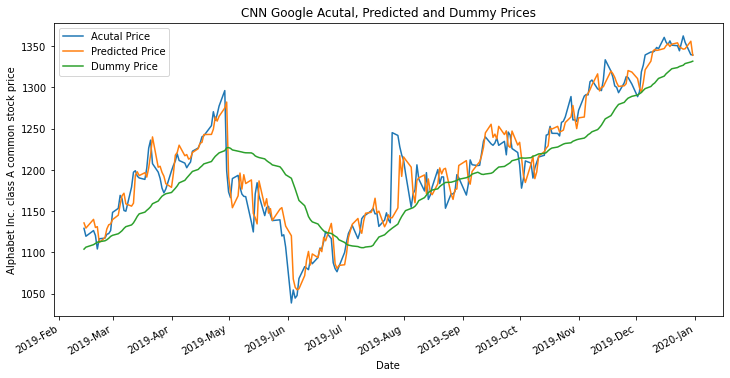

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

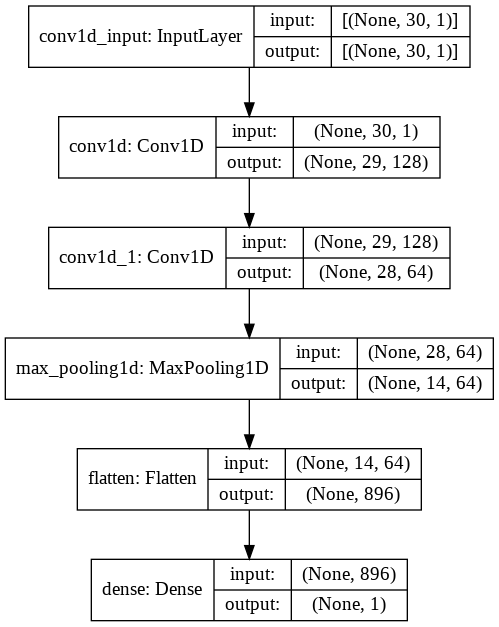

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004383800758833143
RMSE:  0.06621027683700728
MAE:  0.04811244416329676
Dummy MSE:  0.01786933010743511
Dummy RMSE:  0.13367621369351806
Dummy MAE:  0.10749275974657799


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_Google/assets
